In [126]:
import os
import torch
from torchvision.datasets import CocoDetection
from PIL import Image, ImageDraw, ImageFont

from yolo.visualize import render_bounding_boxes
from torchvision.models import get_model
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNeXt50_32X4D_Weights
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.ops.feature_pyramid_network import LastLevelP6P7

from torchvision.ops import Conv2dNormActivation
from functools import partial

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
dataset_root = "/media/bryan/ssd01/fiftyone/coco-2017"
val_dataset = CocoDetection(
    root = os.path.join(dataset_root, "validation", "data"),
    annFile = os.path.join(dataset_root, "validation", "labels.json"),
)
# train_dataset = CocoDetection(
#     root = os.path.join(dataset_root, "train", "data"),
#     annFile = os.path.join(dataset_root, "train", "labels.json"),
# )

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [31]:
cat_id2name = {id: d["name"] for id,d in val_dataset.coco.cats.items()}

In [37]:
sample = val_dataset[0]

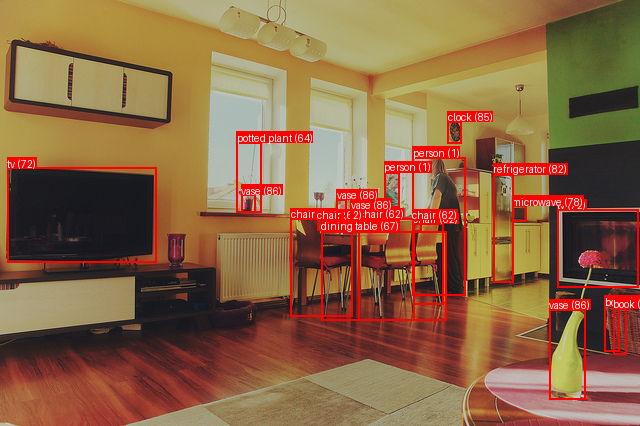

In [38]:
render_bounding_boxes(sample[0], sample[1], cat_id2name)

In [93]:
# backbone = resnet_fpn_backbone(
#     backbone_name='resnext50_32x4d',
#     weights=ResNeXt50_32X4D_Weights.DEFAULT,
#     trainable_layers=5,
#     norm_layer = torch.nn.BatchNorm2d,
#     extra_blocks = LastLevelP6P7(256, 256)
# )

In [129]:
backbone.inplanes

2048

In [166]:
from typing import List, Dict
from torch import nn
from collections import OrderedDict

class YoloBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        act_layer = partial(nn.LeakyReLU, negative_slope = 0.1)
        
        self.layers = nn.Sequential(
            Conv2dNormActivation(in_channels, out_channels // 2, kernel_size=1, norm_layer = nn.BatchNorm2d, activation_layer=act_layer),
            Conv2dNormActivation(out_channels // 2, out_channels, kernel_size=3, norm_layer = nn.BatchNorm2d, activation_layer=act_layer),
            Conv2dNormActivation(out_channels, out_channels // 2, kernel_size=1, norm_layer = nn.BatchNorm2d, activation_layer=act_layer),
            Conv2dNormActivation(out_channels // 2, out_channels, kernel_size=3, norm_layer = nn.BatchNorm2d, activation_layer=act_layer),
            Conv2dNormActivation(out_channels, out_channels // 2, kernel_size=1, norm_layer = nn.BatchNorm2d, activation_layer=act_layer),
        )
        self.final_layer = Conv2dNormActivation(out_channels // 2, out_channels, kernel_size=3, norm_layer = nn.BatchNorm2d, activation_layer=act_layer)
        self.in_channels = in_channels
        self.out_channels = out_channels
    
    def forward(self, x):
        intermediate = self.layers(x)
        return intermediate, self.final_layer(intermediate)

class YoloUpsample(nn.Sequential):
    def __init__(self, in_channels: int):
        act_layer = partial(nn.LeakyReLU, negative_slope = 0.1)
        out_channels = in_channels // 2
        layers = [
            Conv2dNormActivation(in_channels, out_channels, kernel_size=1, norm_layer = nn.BatchNorm2d, activation_layer=act_layer),
            nn.Upsample(scale_factor=2, mode="nearest"),
        ]
        super().__init__(*layers)
        self.out_channels = out_channels

    
class YoloFPN(torch.nn.Module):
    def __init__(
        self,
        in_channels_list : List[int] = [512, 1024, 2048],
        out_channels_list : List[int] = [256, 512, 1024],
    ):
        super().__init__()
        # FPN must have 3 scales
        assert len(in_channels_list) == len(out_channels_list)
        assert len(out_channels_list) == 3
        
        lateral_convs = []
        for i, (in_channels, out_channels) in enumerate(zip(in_channels_list, out_channels_list)):
            lat_out_channels = out_channels if i == len(in_channels_list) - 1 else out_channels // 2
            lateral_convs.append(Conv2dNormActivation(in_channels, lat_out_channels, kernel_size=1, norm_layer = nn.BatchNorm2d, activation_layer=None))
        
        self.lateral_convs = nn.ModuleList(lateral_convs)
        
        # YoloBlocks will be applied after the concatenated features
        self.stages = nn.ModuleList([
            YoloBlock(out_channels, out_channels) for out_channels in out_channels_list
        ])
        self.upsamples = nn.ModuleList([YoloUpsample(out_channels // 2) for out_channels in out_channels_list[1:]])
       
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        assert len(x) == len(self.lateral_convs)
        names = list(x.keys())
        feature_maps = list(x.values())
            
        results = []
        x_up = None
        for idx in range(len(x) - 1, -1, -1):
            print(f"[{idx}] feature_map {feature_maps[idx].shape}")
            x_lateral = self.lateral_convs[idx](feature_maps[idx])
            print(f"[{idx}] x_lateral {x_lateral.shape}")

            if idx < len(x) - 1:
                x_lateral = torch.cat([x_up, x_lateral], dim=1)
                print(f"[{idx}] x_lateral {x_lateral.shape} after cat")

            
            x_to_up, x_to_head = self.stages[idx](x_lateral)
            print(f"[{idx}] x_to_up {x_to_up.shape}")
            print(f"[{idx}] x_to_head {x_to_head.shape}")

            if idx > 0:
                # because there is always 1 fewer upsample
                x_up = self.upsamples[idx - 1](x_to_up)
                print(f"[{idx}] x_up {x_up.shape} after upsample")

            results.insert(0, x_to_head)
        
        out = OrderedDict([(k,v) for k,v in zip(names, results)])
        return out

In [167]:
backbone = get_model("resnext50_32x4d", weights=ResNeXt50_32X4D_Weights.DEFAULT, norm_layer = torch.nn.BatchNorm2d)
returned_layers = [2,3,4] # final 3 layers
return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)} 
in_channels_stage2 = backbone.inplanes // 8
in_channels_list = [in_channels_stage2 * 2 ** (i - 1) for i in returned_layers]
body = IntermediateLayerGetter(backbone, return_layers = return_layers)
fpn = YoloFPN(in_channels_list, [256, 512, 1024])


In [168]:
x = torch.rand(1,3,608,608)
x = torch.rand(1,3,416,416)
output_body = body(x)
output_fpn = fpn(output_body)

[2] feature_map torch.Size([1, 2048, 13, 13])
[2] x_lateral torch.Size([1, 1024, 13, 13])
[2] x_to_up torch.Size([1, 512, 13, 13])
[2] x_to_head torch.Size([1, 1024, 13, 13])
[2] x_up torch.Size([1, 256, 26, 26]) after upsample
[1] feature_map torch.Size([1, 1024, 26, 26])
[1] x_lateral torch.Size([1, 256, 26, 26])
[1] x_lateral torch.Size([1, 512, 26, 26]) after cat
[1] x_to_up torch.Size([1, 256, 26, 26])
[1] x_to_head torch.Size([1, 512, 26, 26])
[1] x_up torch.Size([1, 128, 52, 52]) after upsample
[0] feature_map torch.Size([1, 512, 52, 52])
[0] x_lateral torch.Size([1, 128, 52, 52])
[0] x_lateral torch.Size([1, 256, 52, 52]) after cat
[0] x_to_up torch.Size([1, 128, 52, 52])
[0] x_to_head torch.Size([1, 256, 52, 52])


In [169]:
print([(k, v.shape) for k, v in output_fpn.items()])

[('0', torch.Size([1, 256, 52, 52])), ('1', torch.Size([1, 512, 26, 26])), ('2', torch.Size([1, 1024, 13, 13]))]
